# HOW TO RETRIEVE AND USE SOIL GAS DATA

The data are available through the [GeoNet GitHub data repository](https://github.com/GeoNet/data/tree/main/soil-gas), and more information on the dataset can be found there.

## &nbsp;Table of contents
### 1. Basic requirements
### 2. Data retrieval and preparation
### 3. Mapping

## &nbsp;1. Basic requirements

### Import required Python modules/libraries

In [1]:
#pandas for data analysis
import pandas as pd

#for mapping
import cartopy.crs as ccrs
from osgeo import gdal, osr
gdal.UseExceptions()

#matplotlib for graphing
import matplotlib.pyplot as plt
import matplotlib

### A function to find bounds of a georeferenced image, such as geotiff

In [2]:
def findbounds(infile, ds):
    xpx = ds.RasterXSize
    ypx = ds.RasterYSize
    
    tfw = open(infile, 'r')
    content = [line.strip() for line in tfw.readlines()]
    left = float(content[4])
    top = float(content[5])
    right = float(content[4]) + xpx * float(content[0])
    bottom = float(content[5]) + ypx * float(content[3])
    return (left, right, bottom, top)

## &nbsp;2. Data retrieval and preparation

We will work with data from Moutohorā Whale Island where there have been several soil gas surveys. We'll focus on the one in January 2025.

In [3]:
url = 'https://raw.githubusercontent.com/GeoNet/data/refs/heads/main/soil-gas/'

In [4]:
sgfile = url+'MoutohoraWhaleIsland_2025-01-29.csv'
df = pd.read_csv(sgfile)

In [5]:
df.head()

,MeasurementNumber,NZTM-mE,NZTM-mN,CO2,CH4,H2S,GroundTemperature
0,1,1949107,5802678,44.2,0.1,NaN,21.2
1,2,1949112,5802691,66.1,NaN,NaN,33.2
2,3,1949083,5802705,6.0,NaN,0.0341,21.4
3,4,1949090,5802718,11.7,NaN,0.0387,35.2
4,5,1949072,5802715,13.6,NaN,0.0244,21.5


## &nbsp;3. Mapping

We will display the CO$_2$ data as circles on a map with the circle colour related to the flux.

The basemap is an aerial photo downloaded from https://data.linz.govt.nz/layer/110910-bay-of-plenty-02m-rural-aerial-photos-2021-2022/, available from the [LINZ Data Service](https://data.linz.govt.nz/) at [Toitū Te Whenua Land Information New Zealand](https://www.linz.govt.nz/).

The basemap is a [GeoTIFF](https://en.wikipedia.org/wiki/GeoTIFF) format file. The coordinate reference system is set to [New Zealand Transverse Mercator 2000 (NZTM2000) grid](https://www.linz.govt.nz/guidance/geodetic-system/coordinate-systems-used-new-zealand/projections/new-zealand-transverse-mercator-2000-nztm2000). The associated "tfw" file contains the boundaries and scaling of the image that need to be used to correctly display the background.

### Read the basemap image and setup for display

In [6]:
base = './basemap/'
fname = base+'bay-of-plenty-02m-rural-aerial-photos-2021-2022.tif'
tfwfile = base+'bay-of-plenty-02m-rural-aerial-photos-2021-2022.tfw'
ds = gdal.Open(fname)
data = ds.ReadAsArray()

extent = findbounds(tfwfile, ds)
print (extent)

projection = ccrs.epsg('2193') 

(1948944.3000002229, 1949307.5000002228, 5802620.300000664, 5803155.300000664)


### Make the map.

The [plasma](https://matplotlib.org/stable/users/explain/colors/colormaps.html) colourmap is used. This is perceptually uniform so the lightness value increases monotonically through the colourmap. 
This stops the viewer's eyes being drawn to parts of a map that contain certain colours.

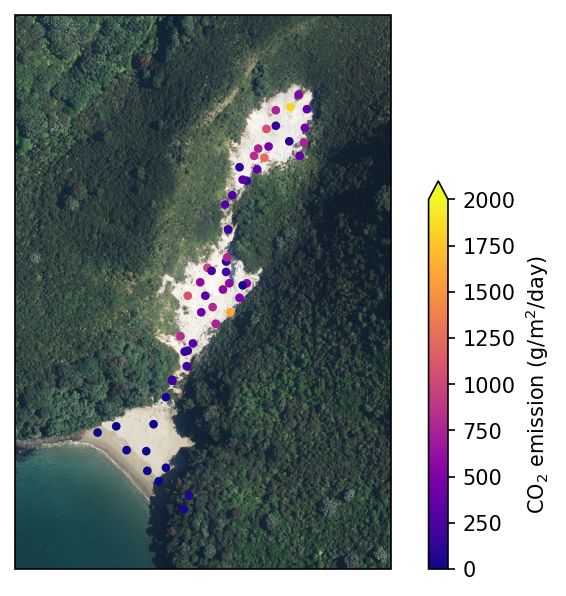

In [7]:
subplot_kw = dict(projection=projection)
fig,ax = plt.subplots(subplot_kw=subplot_kw, dpi=150)

#show the image
#need the three visible data channels and transpose those so that imshow can display.
img = ax.imshow(data[:3, :, :].transpose((1, 2, 0)) , extent=extent)

#set axis limits of the map to match photo basemap
ax.set_xlim(left=extent[0], right=extent[1])
ax.set_ylim(bottom=extent[2], top=extent[3])

#display each observation, the scale is set to 0-2000 to match what GNS Science's Volcano Monitoring Group do for this map
co2 = ax.scatter(df['NZTM-mE'], df['NZTM-mN'], s=10, c=df['CO2'], cmap='plasma', vmin=0, vmax=2000)

#add a colourbar scale and makes it look reasonable
fig.colorbar(co2, location='right', orientation='vertical', fraction=0.05, shrink=0.7,
             extend='max', anchor=(0,0), label='CO$_2$ emission (g/m$^2$/day)')